In [1]:
%load_ext autoreload
%autoreload 2

# Train

In [7]:
import os

import torch
import numpy as np
import tqdm
from torch.utils.data import DataLoader
from datasets import train_dataset, test_dataset
from torch.optim import AdamW
from argparse import ArgumentParser

from GAU import GAUNet, loss_fn, align
from params_gau import params

lr = 1e-3
batch_size = 128
epoch = 50

device = torch.device('cuda:0')

model = GAUNet(params=params).to(device)
try: 
    model.load_state_dict(torch.load(r'/home/wyl/projects/_BSS_hijack/_end_to_end_compare/03_GAU/ckpt/ckpt.pth'))
    print('model loaded')
except:
    print('model does not exist')

train_data = train_dataset()
test_data = test_dataset()
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr, eps=1e-7)

tqdm_epoch = tqdm.tqdm(range(epoch))

train_loss_list = []
test_loss_list = []

for _ in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for train_data, truth in data_loader:
        train_data = align(train_data.squeeze(1)).to(device)
        truth = align(truth.squeeze(1)).to(device)

        output = model(train_data)
        loss = loss_fn(output, truth)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() * train_data.shape[0]
        num_items += train_data.shape[0]

    with torch.no_grad():

        test_loss = 0.
        test_items = 0
        for test_data, test_truth in test_loader:
            test_data = align(test_data.squeeze(1)).to(device)
            test_truth = align(test_truth.squeeze(1)).to(device)

            output = model(test_data)
            loss = loss_fn(output, test_truth)

            test_loss += loss.item() * train_data.shape[0]
            test_items += train_data.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f},   Test Loss: {:5f}'.format(avg_loss / num_items, test_loss / test_items))
    torch.save(model.state_dict(), r'/home/wyl/projects/_BSS_hijack/_end_to_end_compare/03_GAU/ckpt/ckpt.pth')

    train_loss_list.append((avg_loss / num_items))
    test_loss_list.append((test_loss / test_items))

train_loss_npy = np.array(train_loss_list)
test_loss_npy = np.array(test_loss_list)
np.save(r'/home/wyl/projects/_BSS_hijack/_end_to_end_compare/03_GAU/loss/train_loss_1.npy', train_loss_npy)
np.save(r'/home/wyl/projects/_BSS_hijack/_end_to_end_compare/03_GAU/loss/test_loss_1.npy', test_loss_npy)

model loaded


Average Loss: 0.116758,   Test Loss: 0.132977:   2%|▏         | 1/50 [00:08<06:42,  8.22s/it]


KeyboardInterrupt: 

# Eval

In [1]:
import torch
from GAU import GAUNet
import matplotlib.pyplot as plt
from datasets import train_dataset, test_dataset
from torch.utils.data import DataLoader, RandomSampler
from params_gau import params

seed = torch.manual_seed(1001)
train_sampler = RandomSampler(train_dataset(), replacement=False, num_samples=100)
test_sampler = RandomSampler(test_dataset(), replacement=False, num_samples=100)
train_loader = DataLoader(train_dataset(), batch_size=20, sampler=train_sampler)
test_loader = DataLoader(test_dataset(), batch_size=20, sampler=test_sampler)

train_data, train_truth = next(iter(train_loader))
test_data, test_truth = next(iter(test_loader))

train_data = train_data.squeeze(1).to(torch.float32)
train_truth = train_truth.squeeze(1).to(torch.float32)

test_data = test_data.squeeze(1).to(torch.float32)
test_truth = test_truth.squeeze(1).to(torch.float32)

In [4]:
from GAU import loss_fn

# end to end eval
model = GAUNet(params)
try: 
    model.load_state_dict(torch.load(r'/home/wyl/projects/_BSS_hijack/_end_to_end_compare/03_GAU/ckpt/ckpt.pth'))
    print('::: model loaded :::')
except:
    print('::: ckpt does not exist :::')
model.eval()

seed = torch.manual_seed(1001)
randint = torch.randint(0, 20, (1,))    # 随机一个数字 for 结果展示

with torch.no_grad():
    train_output = model(train_data)
    test_output = model(test_data)

result_model = train_output[randint].squeeze(0)
truth_model = train_truth[randint].squeeze(0)

result_test = test_output[randint].squeeze(0)
result_truth = test_truth[randint].squeeze(0)

loss_model_train = loss_fn(train_output, train_truth)
loss_model_test = loss_fn(test_output, test_truth)

print(loss_model_train)
print(loss_model_test)

::: model loaded :::
tensor(0.1117)
tensor(0.1362)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


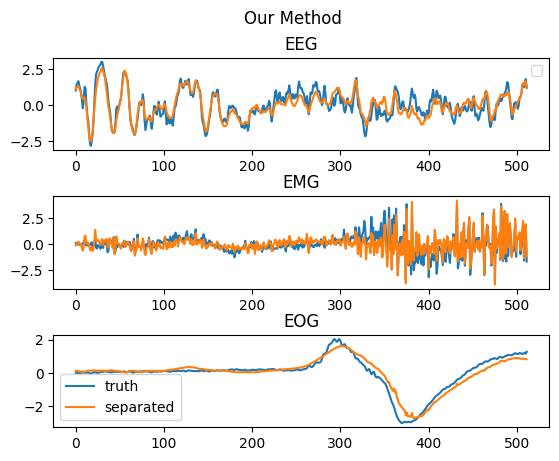

In [6]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=1)

axs[0].plot(truth_model[0])
axs[0].plot(result_model[0])
axs[0].set_title("EEG")

# axs[0].set_title("ground truth EEG")
axs[0].legend()

axs[1].plot(truth_model[1])
axs[1].plot(result_model[1])
axs[1].set_title("EMG")

# axs[1].set_title("ground truth EMG")
axs[2].plot(truth_model[2], label='truth' )
axs[2].plot(result_model[2], label='separated')
axs[2].set_title("EOG")
axs[2].legend()
# axs[2].set_title("ground truth EOG")

plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.5)

fig.suptitle('Our Method')

plt.show()